In [1]:
# TODO: clean imports
import numpy as np
import pandas as pd
from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.ensemble import RandomForestClassifier


from ollama import chat
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)
# import torch
# import torch.nn as nn
# import pytorch_lightning as pl
# from torch.utils.data import DataLoader, TensorDataset
# from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
# import torchmetrics

import os
from glob import glob
from pathlib import Path
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib import pyplot as plt

# override all pandas display limits
pd.options.display.max_columns = None
pd.options.display.max_rows = None



In [2]:
# load parquet files
data_path = Path("../../data")
notebooks_path = Path(os.getcwd())
data_dir = {}

##unsafe
# for file_path in list((notebooks_path / data_path).glob("*.parquet")):
#     print(f"Reading {file_path}")
#     # retrieve the name of the file without the extension for all OS
#     data = pd.read_parquet(file_path)
#     # if "Time" in df.columns:
#     #     df["Time"] = pd.to_datetime(df["Time"])
#     data_dir[str(file_path).replace("\\", "/").split("/")[-1].split(".")[0].replace("-", "_")] = data

for file_path in (notebooks_path / data_path).glob("set*.parquet"):
    var_name = file_path.stem.replace("-", "_")
    globals()[var_name] = pd.read_parquet(file_path)
    print(f"Reading {file_path} -> {var_name}")


ID_vars = ["PatientID", "Time", "RecordID"]
# stationary variables
stationary_vars = ["Age", "Gender", "Height"] #, "ICUType"]
# dynamic variables
dynamic_vars = set_a.columns.difference(stationary_vars + ID_vars).tolist()


Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-a-filled.parquet -> set_a_filled
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-b.parquet -> set_b
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-a.parquet -> set_a
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-c-filled.parquet -> set_c_filled
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-c.parquet -> set_c
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-b-filled.parquet -> set_b_filled


In [3]:
def extract_features(df):
    # df = df.copy()
    df['Time'] = df['Time'].str.replace(':00', '').astype(float)  # Convert '00:00' to 0.0, etc.
    features = []

    for patient_id, group in tqdm(df.groupby("RecordID")):
        row = {'RecordID': patient_id}

        # Time series variables
        ts_vars = [col for col in df.columns if col not in ['RecordID', 'Time']]

        for var in ts_vars:
            times = group['Time']
            vals = group[var].dropna()
            row[f'{var}_mean'] = vals.mean() if not vals.empty else np.nan
            row[f'{var}_max'] = vals.max() if not vals.empty else np.nan
            row[f'{var}_last'] = vals.iloc[-1] if not vals.empty else np.nan
            
            row[f'{var}_std'] = vals.std() if not vals.empty else np.nan
            row[f'{var}_missing_frac'] = vals.isna().sum() / len(vals)
            if vals.count() >= 2:
                # Fit linear regression for slope
                x = times[vals.notnull()].values.reshape(-1, 1)
                y = vals.values.reshape(-1, 1)
                model = LinearRegression()
                model.fit(x, y)
                row[f'{var}_slope'] = model.coef_[0][0]
            else:
                row[f'{var}_slope'] = np.nan


        features.append(row)

    return pd.DataFrame(features)

# for key in ["a", "b", "c"]:
#     print(f"Extracting set_{key}") 
#     df = extract_features(globals()[f"set_{key}_filled"])
#     df.to_csv(notebooks_path / data_path / Path(f"features_{key}.csv"))

In [4]:
for file_path in (notebooks_path / data_path).glob("features*.csv"):
    var_name = file_path.stem.replace("-", "_")
    globals()[var_name] = pd.read_csv(file_path)
    print(f"Reading {file_path} -> {var_name}")

Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/features_a.csv -> features_a
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/features_c.csv -> features_c
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/features_b.csv -> features_b


          Feature  Importance
86       GCS_last    0.030602
84       GCS_mean    0.020119
66     Urine_mean    0.018542
89      GCS_slope    0.017366
128      BUN_last    0.013003
126      BUN_mean    0.012833
138     HCO3_mean    0.011241
44       WBC_last    0.010143
1         Age_max    0.009277
72     PaCO2_mean    0.008891
131     BUN_slope    0.008636
192  Glucose_mean    0.008606
93         pH_std    0.008586
69      Urine_std    0.008528
30        HR_mean    0.008468
2        Age_last    0.008306
60      FiO2_mean    0.008185
210       Na_mean    0.008067
67      Urine_max    0.007946
143    HCO3_slope    0.007859


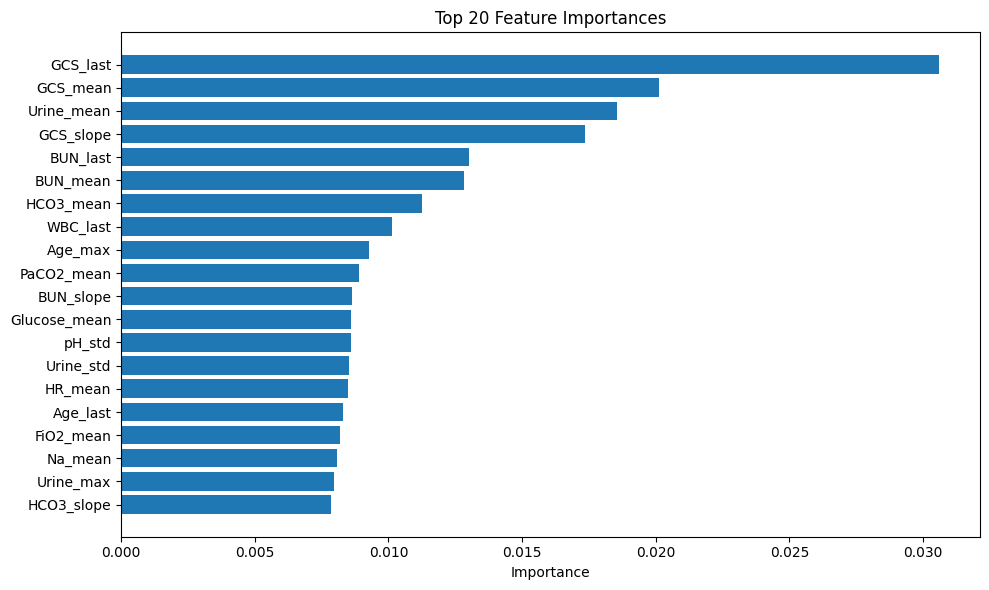

In [5]:
# Train a Random Forest to check feature importance for classification
def split_labels_and_features(df):
    exclude = ["In-hospital_death", "RecordID", "Unnamed", "ICUType"]
    labels = df['In-hospital_death_mean']
    features = df.loc[:, ~df.columns.str.contains("|".join(exclude))].copy()

    return features, labels

## top k features
top_k_features = 20

X_train, y_train = split_labels_and_features(features_a)

# Assuming you've already trained your Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Extract importances
importances = rf.feature_importances_

# Create a sorted DataFrame
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"f{i}" for i in range(X_train.shape[1])]
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Print top features
print(importance_df.head(top_k_features))

# Optional: plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"][:top_k_features][::-1], importance_df["Importance"][:20][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


In [38]:
def generate_patient_summary(row):
    return (
        f"age {int(row['Age_max'])} years, "
        f"last GCS score {int(row['GCS_last'])}, "
        f"mean GCS score {int(row['GCS_mean'])}, "
        f"mean urine output {round(row['Urine_mean'])} ml, "
        f"last BUN level {round(row['BUN_last'], 1)} mg/dL, "
        f"last WBC count {round(row['WBC_last'], 1)} ×10^9/L, "
        f"mean heart rate {int(row['HR_mean'])} bpm, "
        f"mean FiO₂ {int(row['FiO2_mean'])}%, "
        f"variation in pH {round(row['pH_std'], 2)}, "
        f"mean bicarbonate {int(row['HCO3_mean'])} mmol/L"
    )
def build_few_shot_prompt(df, label_col="In-hospital_death", max_examples=3, scoring = False):
    assert len(df) > max_examples, "Not enough patients for few-shot + test split."

    if scoring: 
         force_model_output = "Respond with exactly one digit between 1-10 indicating the probability of survival, where 10 is most likely survival and 1 least likely."
    else: 
        force_model_output = "Respond with exactly one word: either 'died' or 'survived'."
        
    prompt = f"You are a medical AI assistant. Based on ICU data summaries, predict patient outcomes. {force_model_output} Do not explain your answer.\n\n"


    # Few-shot examples
    for i in range(max_examples):
        row = df.iloc[i]
        summary = generate_patient_summary(row)
        outcome = "died" if row[label_col] == 1 else "survived"
        prompt += f"Example {i+1}:\nPatient summary: {summary}.\nOutcome: {outcome}\n\n"

    # Add test cases
    test_cases = []
    outcomes = []
    for i in range(max_examples, len(df)):
        row = df.iloc[i]
        summary = generate_patient_summary(row)
        test_cases.append(f"Patient summary: {summary}.\nOutcome:")
        outcomes.append(r"died" if row[label_col] == 1 else "survived")

    return prompt, test_cases, outcomes

def query_llm(prompt, test_case, model='gemma2:2b'):
    messages = [{'role': 'user', 'content': f"{prompt}\n\n{test_case}"}]
    stream = chat(model=model, messages=messages, stream=True)

    output = ""
    for chunk in stream:
        output += chunk['message']['content']
    return output.strip()

from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

def evaluate_llm_predictions(prompt, test_cases, outcomes, model="chronos", max_cases=None, verbose = False):
    y_true = []
    y_pred = []
    y_scores = []  # for optional numeric scoring later

    for i, test_case in tqdm(enumerate(test_cases[:max_cases]), desc="Patient Cases", total = max_cases):
        
        prediction_raw = query_llm(prompt, test_case, model=model).lower().strip()
       
        truth = 1 if outcomes[i] == "died" else 0

        # Parse prediction
        if "died" in prediction_raw:
            pred = 1
            prob = 0.0
        elif "survived" in prediction_raw:
            pred = 0
            prob = 1.0
        elif prediction_raw.isdigit():
            # If using scoring (e.g., 1–10), treat >5 as survival
            score = int(prediction_raw)
            pred = 0 if score >= 6 else 1
            prob = score / 10
        else:
            print("⚠️ Unexpected output format, treating as incorrect.")
            pred = -1
            prob = 0.5

        if verbose: 
            print(f"\n--- Test Case {i+1} ---")
            print(f"Raw LLM Output: {prediction_raw}")
            print(f"Prediction: {'died' if pred == 1 else 'survived'}")
            print(f"Truth: {'died' if truth == 1 else 'survived'}")

        y_true.append(truth)
        y_pred.append(pred)
        y_scores.append(prob)

    # Filter valid predictions
    valid_idx = [i for i, p in enumerate(y_pred) if p in [0, 1]]
    y_true = [y_true[i] for i in valid_idx]
    y_pred = [y_pred[i] for i in valid_idx]
    y_scores = [y_scores[i] for i in valid_idx]

    # Metrics
    print("\n📊 Confusion Matrix:")
    # print(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("LLM Predictions: Confusion Matrix")
    plt.show()

    if len(set(y_true)) == 2:
        auroc = roc_auc_score(y_true, y_scores)
        auprc = average_precision_score(y_true, y_scores)
        print(f"AUROC : {auroc:.4f}")
        print(f"AUPRC : {auprc:.4f}")

        RocCurveDisplay.from_predictions(y_true, y_scores)
        plt.title("ROC Curve")
        plt.show()

        PrecisionRecallDisplay.from_predictions(y_true, y_scores)
        plt.title("Precision-Recall Curve")
        plt.show()
    else:
        print("⚠️ Not enough class diversity to compute AUROC/AUPRC.")

    return y_true, y_pred, y_scores


In [39]:
# Assume df is your test set DataFrame with top features + labels
# !ollama serve
# !ollama list

In [40]:
# MVP
# max_cases = 1
# scoring_bool = True

# prompt, test_cases, outcomes = build_few_shot_prompt(features_a, label_col = "In-hospital_death_mean", scoring = scoring_bool)


# for i, test_case in enumerate(test_cases[:max_cases]):
#     print(f"\n--- Test Case {i+1} ---")
#     prediction = query_llm(prompt, test_case).lower()
#     print(f"Prediction: {prediction}")
#     print(f"Truth: {outcomes[i]}")


Patient Cases:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Confusion Matrix:
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1]


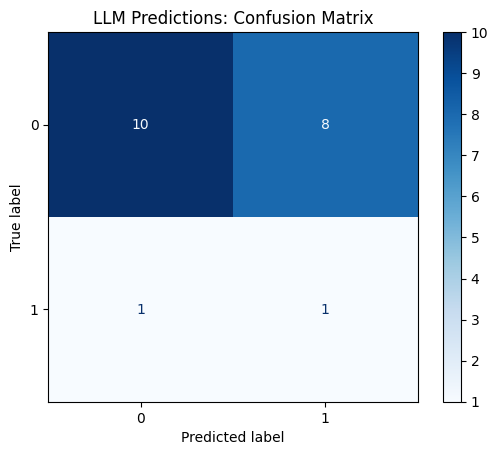

AUROC : 0.4722
AUPRC : 0.0955


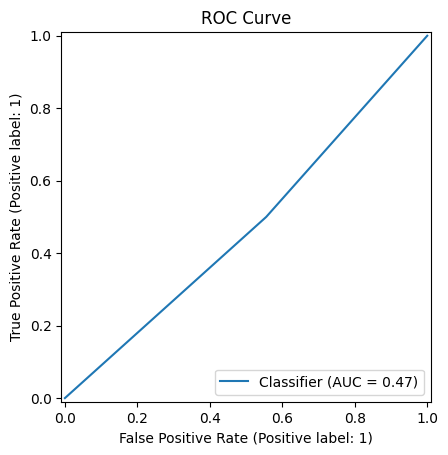

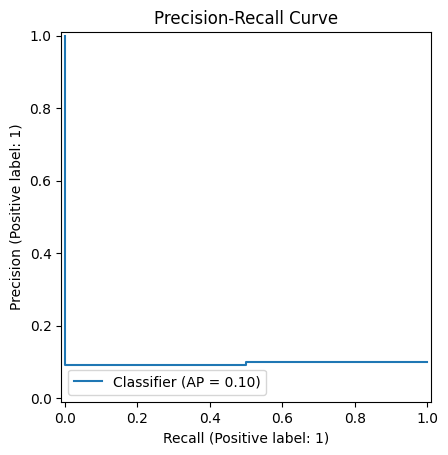

([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
 [1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  0.0])

In [41]:
prompt, test_cases, outcomes = build_few_shot_prompt(
    features_a,
    label_col="In-hospital_death_mean",
    scoring=False
)

y_true, y_pred, y_scores = evaluate_llm_predictions(prompt, test_cases, outcomes, model="gemma2:2b", max_cases=20)
